In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns, warnings
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')
from causalgraphicalmodels import CausalGraphicalModel
from cProfile import label
%matplotlib inline
import linearmodels.iv.model as lm
from linearmodels.iv import IV2SLS
import plotnine as p

In [2]:
from causalgraphicalmodels import CausalGraphicalModel
import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
#import plotnine as p
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels.iv.model as lm
from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import pyreadr

# REPORTE 7:

Trabajo conjunto con Roxana Rodríguez (20200373), Greysi Arrelucea (20200279) y María Fernanda Carrillo (20201596)

## Parte 1: Código

## Ploteo de Histogramas

### Subiendo la data

In [3]:
data = pd.read_csv('https://github.com/matheusfacure/python-causality-handbook/raw/master/causal-inference-for-the-brave-and-true/data/online_classroom.csv')
print(data.shape)
data.head()

(323, 10)


,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000
2,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,83.37000
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,90.01994
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000


#### Creación de la columna que identifica el tipo de clases:

In [8]:
# creado una columna extra para clasificar
data_2 = (data
 .assign(class_format = np.select(
     [data["format_ol"].astype(bool), data["format_blended"].astype(bool)],
     ["online", "blended"],
     default="face_to_face" #create a new variable
 ))) #group by the new variable (treatments)

In [9]:
data_2

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam,class_format
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997,face_to_face
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000,face_to_face
2,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,83.37000,blended
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,90.01994,blended
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000,online
...,...,...,...,...,...,...,...,...,...,...,...
318,0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,68.36000,blended
319,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,70.05000,online
320,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,66.69000,online
321,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,83.29997,online


### Creación de los dummies

In [10]:
pd.get_dummies(data_2, columns=["class_format"]).head()

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam,class_format_blended,class_format_face_to_face,class_format_online
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997,0,1,0
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000,0,1,0
2,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,83.37000,1,0,0
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,90.01994,1,0,0
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000,0,0,1


### Creación del Histograma

Text(19.309791666666662, 0.5, 'Alumnos')

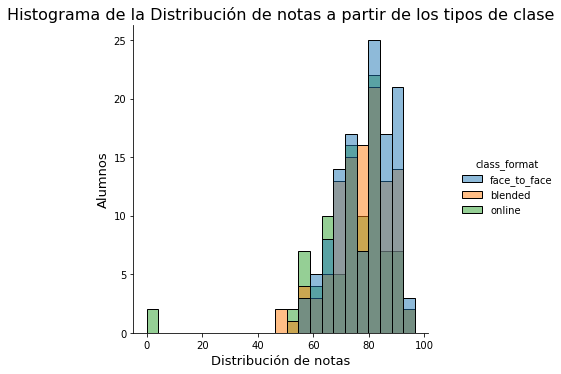

In [13]:
sns.displot(data_2, x="falsexam", hue="class_format")  
plt.title("Histograma de la Distribución de notas a partir de los tipos de clase", fontsize=16)
plt.xlabel("Distribución de notas", fontsize=13)
plt.ylabel("Alumnos", fontsize=13)

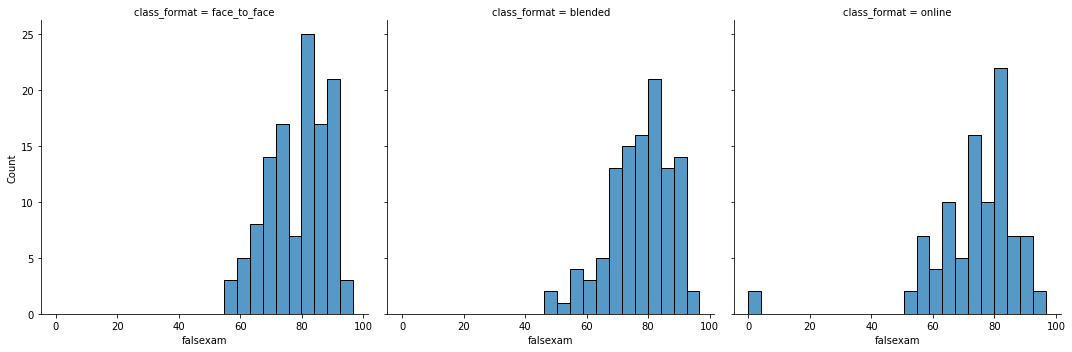

In [24]:
sns.displot(data=data_2, x="falsexam", col="class_format")

A partir de estos histogramas logramos apreciar que hay una diferencia en la distribución de la frecuencia del promedio de notas según el tipo de modalidad. En el grupo de clases presenciales hay menos distribución y presentan frecuencias más altas, en el grupo de clases híbridas hay mayor disperción y variación de las notas, pero todavía vemos altos picos en notas altas, y en el formato de clases online hay un poquito menos de disperción, pero si hay una menor frecuencia de notas altas e incluso hay datos atípicos. En este sentido, se podría concluir que los estudiantes que tienden a obtener notas más altas reciben clases presenciales, los estudiantes que tiende a obtener notas medianamente altas y medio son quienes reciben clases en el formato híbido, y los estudiantes que tienden a obtener notas con una distribución más baja en comparación con otros son quienes reciben clases online. 

## Difference-in-means estimator.

Crear un nuevo dataset donde solo incluyan estos dos grupos
Calculan el promedio del grupo online lessons
Calculan el primdeio del grupo face-to-face
Toman la diferencia entre el valor encontrado en 2 y el valor en 3.

### Crear un nuevo dataset donde solo incluyan estos dos grupos: face-to-face y online lessons

In [14]:
d_mean = data_2[['class_format','falsexam']]
d_mean.head(10)

,class_format,falsexam
0,face_to_face,63.29997
1,face_to_face,79.96000
2,blended,83.37000
3,blended,90.01994
4,online,83.30000
5,online,88.34996
6,blended,78.40000
7,face_to_face,90.00000
8,face_to_face,88.31000
9,online,73.37000


#### Separar los grupos entre quienes reciben clases presenciales y aquellos que reciben clases virtuales

In [15]:
grupos_div=["face_to_face", "online"] #
grupos_div

['face_to_face', 'online']

#### Crear nuevo subdata que solo tome en cuenta los valores de estos dos grupos 

In [17]:
D_MEAN = d_mean[d_mean['class_format'].isin(grupos_div)]
D_MEAN

,class_format,falsexam
0,face_to_face,63.29997
1,face_to_face,79.96000
4,online,83.30000
5,online,88.34996
7,face_to_face,90.00000
...,...,...
316,face_to_face,91.65000
317,face_to_face,84.99000
319,online,70.05000
320,online,66.69000


### Calcular el promedio de las notas del face-to-face clases y los online lessons

In [18]:
D_MEAN.groupby(["class_format"]).mean()

,falsexam
class_format,
face_to_face,78.547485
online,73.635263


A partir de estos datos, se obserba que el promedio de las notas de aquellos que llevaron clases presenciales (face-to-face clases) es 78.54, Mientras que el promedio de las notas de aquellos que llevaron clases online es 73,63. En este caso, parece ser que quines recibieron clases presenciales se desempeñaron mejor y por ende se podría decir que existe una correlación entre este tipo de formato de clase y el desempeño académico plasmado en las notas

### Diferencia de promedios del grupo online lessons y del grupo face-to-face

In [19]:
diferencia_de_medias = 78.547485 - 73.635263
diferencia_de_medias

4.912222

Hay una diferencia de alrededor de 4 puntos entre la media de las notas de aquellos chicos que llevaban clases presenciales y aquellos que llevaron las clases online. En este caso, aquellos que tomaron el curso presenciales obtuvieron un mejor rendimiento y por ende se podría decir que lograron entender mejor los contenidos del curso. 

## Difference-in-means estimator via linear regression 

Deben crear una variable dummy que tome el valor de 1 cuando el tipo de clase sea online y 0 cuando sea face to face.
Luego deben realizar una regresion lineal donde Y = Las notas, T = Dummy creada para el tipo de clase.
Esta regresion es de la siguente manera Y = beta_0 + beta_1*T + e. El valor que encuentren para beta_1 es el average treatment effect que debería ser igual al Difference-in-means estimator encontrado arriba.

#### Crear dummy

In [20]:
reg = d_mean

In [21]:
grupos=["face_to_face", "online"]

#### Crear un nuevo dataset que contenga  los valores de estos grupos

In [22]:
REGRESION = reg[reg['class_format'].isin(grupos)]

#### Regresión lineal con que contiene la modalidad presencial y virtual + Resumen  de los principales datos del valor del componenete beta_1

In [23]:
#OLS
ols_reg = sm.OLS.from_formula("falsexam ~ class_format", 
              data = REGRESION).fit()

ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               falsexam   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     8.554
Date:                Tue, 08 Nov 2022   Prob (F-statistic):            0.00382
Time:                        16:39:23   Log-Likelihood:                -837.85
No. Observations:                 214   AIC:                             1680.
Df Residuals:                     212   BIC:                             1686.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 78.5475      1.113     70.563      0.000      76.353      80.742
class_format[T.online]    -4.9122      1.680     -2.925      0.004      -8.223      -1.601
==============================================================================
Omnibus:                      129.000   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1179.385
Skew:                          -2.179   Prob(JB):                    7.94e-257
Kurtosis:                      13.643   Cond. No.                         2.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A partir de lo realizado, se confirma que  el coeficiente beta_1 tiene el mismo valor que la diferencia entre la media de notas de la modalidad presencial y virtual: 4.9122. Si analizamos el resto de la regresión podemos observar que la dummy es significativa ya que su p-value es menor a 0,05. No obstante, el R2 no es muy alto y por ende el modelo no explica en gran medida la distribución de notas. 

## Parte 2: Reporte

La pregunta de investigación del artículo es: ¿Cuáles son los efectos (positivos y/o negativos) de exponer a los niños que viven en zonas de alta pobreza a un mejor vecindario? Esta investigación toma como base un anterior experimento, Moving to Opportunity (MTO), que se enfocó en el efecto de mudar a familias de alta pobreza a zonas con menor niveles de pobreza, pero ahora se enfocan que se produjo en los niños para ver si los entornos del vecindario juegan un rol importante en el éxito económico, los estudios, la salud, etc. Asimismo, los investigadores buscan saber si las ganancias de mudarse a un área de menor pobreza disminuyen con la edad de un niño en el momento de la mudanza, es decir, saber que tan importante es la variable edad en este experimento. 

Una fortaleza es el uso de datos fiscales que les permitió seguir y rastrear a los adultos del MTO. A comparación con anteriores investigaciones sobre los tratamientos MTO, se basaban solo en datos de registros del seguro estatal de IU y encuestas. Por esta razón, los hallazgos ahora encontrados sobre los efectos de la exposición infantil a mejores vecindarios no fueron evidentes en estudios anteriores porque no tenían datos adecuados a largo plazo para observar la aparición de los impactos de MTO en los ingresos y otros resultados en la edad adulta para los niños que se mudaron a edades tempranas. Asimismo, al darle la debida importancia a la heterogeneidad, que nos permite evidenciar posibles diferencias entre los efectos calculados de la intervención que de aquellos que se esperan de variaciones aleatorias, se logra confirmar que los beneficios a largo plazo de la exposición infantil a vecindarios en mejores condiciones son sólidos a través de todos los géneros, grupos raciales y ubicaciones geográficas. Otro aspecto importante es como analizaron la mejora de condiciones de vida de los niños a su adultez a partir de una multiplicidad de variables como ingresos individuales, ingresos del hogar, asistencia y calidad universitaria, estatus marital y fertilidad, e impuestos pagados, y así comprarlos con los resultados previamente obtenidos del estudio anterior. 

Una debilidad sería que a pesar de que se señala que encontraron que hay mayores ventajas a largo plazo para los niños pequeños que se mudan y hay efectos contrarios cuando los niños son mayores (aunque tampoco son tan significativos), no hay evidencia clara que señale una ‘edad crítica’ para cuando ya no es beneficioso cambiar de vecindario. Esto se debe a los pequeños tamaños de muestra en cada edad infantil, y por ende dificulta establecer un análisis delimitado que luego se pueda aplicar a políticas públicas. De la misma manera, la capacidad del experimento para identificar los efectos causales de la exposición está limitada por el hecho de que el experimento MTO solo ofrece vales aleatorios; es decir, no se aleatorizó la edad a la que los niños se movían, lo que podría correlacionarse con otros factores no observables. Asimismo, es importante señalar que el diseño del experimento MTO no permite distinguir las diferencias en los efectos de la disrupción, tanto si se dieron por la edad de la mudanza o si esta se fue acompañada por el efecto de exposición. Esto dificulta señalar si efectivamente la exposición en la infancia a un mejor ambiente tiene un efecto causal en los resultados a largo plazo, aunque esto no significa que los resultados encontrados no demuestran que un cambio de ambiente a temprana edad es muy beneficioso. 

Esta investigación aporta a los antiguos estudios y tema de investigación en tanto logran reconfirmar que efectivamente la exposición a entornos vecindarios mejorados en adultos no genera un gran impacto, no obstante, sí tienen resultados en niños, es decir, que los efectos del vecindario operan principalmente a través de efectos de desarrollo durante la infancia en lugar de efectos contextuales derivados del desajuste espacial u otras fuerzas. Todo se logra mediante un modelo simple con efectos lineales de exposición infantil junto con un costo fijo de interrupción. Así se encuentra una relación causal entre vivir en barrios menos pobres, y éxitos educativos y económicos a largo plazo. Gracias a los resultados de esta investigación se concluye que es mejor enfocarse en integrar a familias desfavorecidas con niños pequeños en comunidades ingresos no muy bajas (mixtos) para así reducir a largo plazo la pobreza generacional.

Continuando con este tema de investigación Stal y Zuberi (2010) comparan el programa MTO y Bjilmermeet de los Países Bajos para señalar que ambos proyectos revelan los efectos de vivir en vecindarios negativos y como las políticas de ‘desconcentración’ de la pobreza pueden ayudar en mejorar el comportamiento, disposiciones y bienestar de los niños. Sin embargo, también señalan que para que las políticas de reubicación tengan un verdadero efecto se debe tomar en cuenta los contextos específicos de estos grupos (raciales y género) para aumentar los beneficios. Del mismo modo, Lundquist y Massey (2008) reafirman que cambios en el entorno y características de un vecindario tienen un efecto en los jóvenes que puede ser tanto positivo como negativo, pero que va depender de ciertas condiciones. Los efectos dependerán de cuando se dio la mudanza y las características del vecindario, de la interacción entre la duración de la exposición, los efectos de interrupción de la movilidad y las diferencias específicas de la etapa de desarrollo en la vulnerabilidad al mecanismo operativo del efecto de vecindad dado. 

BIBLIOGRAFÍA:

Clampet-Lundquist, S., & Massey, D. S. (2008). Neighborhood effects on economic self-sufficiency: A reconsideration of the Moving to Opportunity experiment. American Journal of Sociology, 114(1), 107-143.
https://www.journals.uchicago.edu/doi/abs/10.1086/588740

Stal, G. Y., & Zuberi, D. M. (2010). Ending the cycle of poverty through socio-economic integration: A comparison of Moving to Opportunity (MTO) in the United States and the Bijlmermeer Revival Project in the Netherlands. Cities, 27(1), 3-12.
https://www.sciencedirect.com/science/article/abs/pii/S0264275109001115